In [1]:
from bokeh.models import *
from bokeh.io import curdoc, show, output_notebook
import pandas as pd
import numpy as np
pd.set_option('display.max_colwidth',-1)
pd.set_option('display.max_rows',100)

In [4]:
# %load ../utils/utils.py
from bokeh.models import *
import pandas as pd


# some constants of use later
fonts = ["helvetica", "arial", "calibri"]
font_sizes = ["10pt", "12pt", "16pt", "24pt", "32pt"]
dash_patterns = ["solid", "dashed", "dotted", "dotdash", "dashdot"]


def obj_props_to_df2(obj):
    """Returns a pandas dataframe of the properties of a bokeh model, each row having
    an attribute, its type (a bokeh property), and the docstring."""
    obj_dict = obj.properties_with_values()
    types = [obj.lookup(x) for x in obj_dict.keys()]
    docs = [getattr(type(obj), x).__doc__ for x in obj_dict.keys()]
    return pd.DataFrame.from_dict(
        {
            "props": list(obj_dict.keys()),
            "values": list(obj_dict.values()),
            "types": types,
            "doc": docs,
        }
    )


def disassemble(object):
    """Given an instance of a bokeh model, takes a stab at constructing a dict that can
    be used in options.py to set options for that model.  Not perfect, so reports its failures."""
    D = {"choices": {}, "strings": {}, "ints": {}, "floats": {}, "colors": {}}
    ct = 0
    axis_df = obj_props_to_df2(object)
    for x in axis_df.iterrows():
        attr, kind, value = x[1]["props"], str(x[1]["types"]), x[1]["values"]
        if kind[:4] == "Bool":
            options = ["True", "False"]
            D["choices"].update({attr: (options, [True, False])})
            ct += 1
            continue
        if kind[:4] == "Enum":
            options = kind[5:-1].split(",")
            options = [x.strip().strip("'") for x in options]
            D["choices"].update({attr: (options, options)})
            ct += 1
            continue
        if kind[:4] == "Numb":
            try:
                D["floats"].update({attr: value["value"]})
            except TypeError:
                D["floats"].update({attr: None})
            except KeyError:
                print("trouble with ", attr, kind, value)
                continue
            ct += 1
            continue
        if kind[:3] == "Int" or kind[:6] == "NonNeg":
            try:
                D["ints"].update({attr: int(value)})
            except TypeError:
                D["ints"].update({attr: 0})
            ct += 1
            continue
        if kind[:4] == "Colo":
            try:
                D["colors"].update({attr: value["value"]})
            except TypeError:
                D["colors"].update({attr: None})
            ct += 1
            continue
        if kind[:4] == "Floa":
            try:
                D["floats"].update({attr: float(value)})
            except TypeError:
                D["floats"].update({attr: float(0.0)})
            ct += 1
            continue
        if kind[:5] == "FontS":
            D["choices"].update({attr: (font_sizes, font_sizes)})
            ct += 1
            continue
        if kind[:4] == "Stri":
            D["strings"].update({attr: str(value)})
            ct += 1
            continue
        if kind[:4] == "Dash":
            D["choices"].update({attr: (dash_patterns, dash_patterns)})
            ct += 1
            continue
        if kind[:4] == "Perc":
            D["floats"].update({attr: float(value)})
            ct += 1
            continue
        if kind.find("Instance") < 0:
            print("cant handle {} of type {}".format(attr, kind))
    print("found {} items".format(ct))
    return D


def explode(F):
    """Given a model, creates a dictionary of options dicts for each submodel referenced
    in the original model.  Keys are model class name concatenated with model instance id"""
    E = {}
    for x in F.references():
        E[x.__class__.__name__ + x.id] = disassemble(x)
    return E




In [6]:
from bokeh.plotting import Figure

In [65]:
def tree(M):
    d = {}
    for m in M.references():
        d[m.id] = set([y.id for y in m.references()])
    return d

In [66]:
F = Figure()
tree(F)

{'1807': {'1804', '1807'},
 '1815': {'1815', '1832'},
 '1814': {'1814'},
 '1794': {'1794',
  '1795',
  '1797',
  '1799',
  '1801',
  '1803',
  '1804',
  '1807',
  '1808',
  '1809',
  '1812',
  '1813',
  '1814',
  '1815',
  '1816',
  '1817',
  '1818',
  '1819',
  '1826',
  '1828',
  '1830',
  '1832'},
 '1803': {'1803', '1804', '1830'},
 '1799': {'1799'},
 '1828': {'1828'},
 '1809': {'1809'},
 '1812': {'1809', '1812'},
 '1813': {'1813'},
 '1830': {'1830'},
 '1817': {'1817'},
 '1819': {'1813', '1814', '1815', '1816', '1817', '1818', '1819', '1832'},
 '1832': {'1832'},
 '1808': {'1808', '1809', '1828'},
 '1804': {'1804'},
 '1801': {'1801'},
 '1797': {'1797'},
 '1818': {'1818'},
 '1816': {'1816'},
 '1795': {'1795'},
 '1826': {'1826'}}

In [67]:
def d(x,y):
    if x & y == x:
        return len(y)-len(x)
    else:
        if y & x ==y:
            return len(x) - len(y)
    return np.inf
    

In [68]:
import networkx as nx


In [69]:
G = nx.Graph()
G.add_nodes_from(tree(F).keys())

In [70]:
len(G.nodes)

22

In [71]:
E = []
from itertools import combinations

In [82]:
T = tree(F)
G = nx.Graph()
G.add_nodes_from(tree(F).keys())
for x,y in combinations(T.keys(), 2):
    if len(T[x] &  T[y])>0:
        if len(T[x])>len(T[y]):
            G.add_edge(x,y,**{'weight':len(T[x])-len(T[y])})
        else:
            G.add_edge(y,x,**{'weight':len(T[y])-len(T[x])})
        

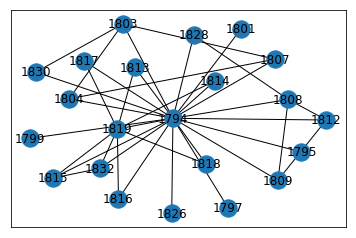

In [83]:
nx.draw_networkx(G)

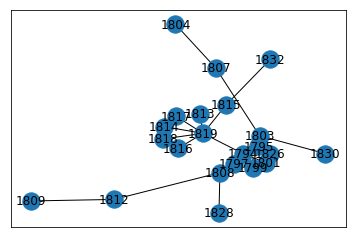

In [87]:
S = nx.minimum_spanning_tree(G)
nx.draw_networkx(S)

In [88]:
S.nodes(data=True)

NodeDataView({'1807': {}, '1815': {}, '1814': {}, '1794': {}, '1803': {}, '1799': {}, '1828': {}, '1809': {}, '1812': {}, '1813': {}, '1830': {}, '1817': {}, '1819': {}, '1832': {}, '1808': {}, '1804': {}, '1801': {}, '1797': {}, '1818': {}, '1816': {}, '1795': {}, '1826': {}})

In [89]:
for x in S.nodes:
    S.node[x]['weight']=len(T[x])

In [90]:
S.nodes(data=True)

NodeDataView({'1807': {'weight': 2}, '1815': {'weight': 2}, '1814': {'weight': 1}, '1794': {'weight': 22}, '1803': {'weight': 3}, '1799': {'weight': 1}, '1828': {'weight': 1}, '1809': {'weight': 1}, '1812': {'weight': 2}, '1813': {'weight': 1}, '1830': {'weight': 1}, '1817': {'weight': 1}, '1819': {'weight': 8}, '1832': {'weight': 1}, '1808': {'weight': 3}, '1804': {'weight': 1}, '1801': {'weight': 1}, '1797': {'weight': 1}, '1818': {'weight': 1}, '1816': {'weight': 1}, '1795': {'weight': 1}, '1826': {'weight': 1}})

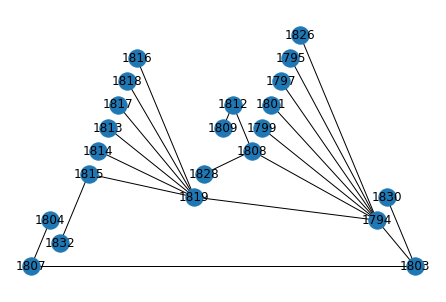

In [110]:
nx.draw_planar(S,with_labels=True)

In [121]:
F.select({'id':'1808'}).references()

{BasicTickFormatter(id='1828', ...),
 BasicTicker(id='1809', ...),
 LinearAxis(id='1808', ...)}

In [122]:
F.select({'id':'1812'}).references()

{BasicTicker(id='1809', ...), Grid(id='1812', ...)}